In here we characterize the colocalization of two genes in two different forms: 
    
    *   A boolean variable is equal to True when two genes are expressed in the same cell.
    *   At a given distance, two genes colocalize if their distance is smaller than the threshold.  We plot the rate as a function of the distance. 
    
    
23/04/25     Jacques Bourg @ Florian Muller lab. Institut Pasteur.

<img src="./HOX_pipeline.png" alt="LNP pipeline" width="1200" height="477">

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import napari

import ipywidgets as widgets
from IPython.display import display

In [2]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))
sys.path.append(str(base_dir / "synthesis"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.plots import Plots
from utils.file_handling import FileProcessor
from segmentation.refine_seg import Segmentation
from synthesis.synthesize import Synthesis

tk  = Track()
sg  = Segmentation()
pt  = Plots()
st  = Synthesis()
fp  = FileProcessor()

In [3]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px')); display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('.gitkeep', 'test_bat…

In [4]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']

In [5]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('EXPERIMENT',), value…

In [6]:
n2       = np.where(np.array(modalities) == dropdown2.value)[0][0]
modality = modalities[n2]; print(modality)

EXPERIMENT


In [7]:
detection_methods = ['UFISH','BIGFISH']
dropdown8         = widgets.Dropdown(options=detection_methods, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown8)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('UFISH', 'BIGFISH'), …

In [8]:
n8    = np.where(np.array(detection_methods) == dropdown8.value)[0][0]
meth  = detection_methods[n8]; print(meth)

BIGFISH


Select the first gene:

In [9]:
channels_cell = constants['CHANNELS'] # DAPI doesn't make sense
dropdown3     = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px')); display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [10]:
n3           = np.where(np.array(channels_cell) == dropdown3.value)[0][0]
chan_g1      = channels_cell[n3]; print(chan_g1)

col_channels = constants['COLORS']  # associated color to this channel
color_g1     = col_channels[n3]; print(color_g1)

HOXC8
green


Select the second gene:

In [11]:
channels_cell = constants['CHANNELS'] # DAPI doesn't make sense
dropdown4 = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'));
display(dropdown4)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [12]:
n4      = np.where(np.array(channels_cell) == dropdown4.value)[0][0]
chan_g2 = channels_cell[n4]; print(chan_g2)

col_channels = constants['COLORS']  # associated color to this channel
color_g2 = col_channels[n4]; print(color_g2)

HOXC10
red


In [13]:
dots_path     = constants[f'DOTS_{meth}_{modality}_{chan_g1}_PATH']
dict_dots_g1  = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

dots_path     = constants[f'DOTS_{meth}_{modality}_{chan_g2}_PATH']
dict_dots_g2  = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

In [14]:
struc_cell              = 'CELL'
file_add_mask_stats_g1  = constants[f"MASK_{modality}_{struc_cell}_STATS_{meth}_{chan_g1}_LIST_PATH"]
dic_masks_cell_stats_g1 = fp.load_pd_distributed_files(file_add_mask_stats_g1)

file_add_mask_stats_g2  = constants[f"MASK_{modality}_{struc_cell}_STATS_{meth}_{chan_g2}_LIST_PATH"]
dic_masks_cell_stats_g2 = fp.load_pd_distributed_files(file_add_mask_stats_g2)

mask_cell_path          = constants[f'MASK_{modality}_DAPI_{struc_cell}_CLEANED_LIST_PATH']
dict_mask_cells_m       = fp.load_masks_distributed_files(mask_cell_path)

In [15]:
name_gene1 = chan_g1
name_gene2 = chan_g2

list_keys = list(np.load(constants[f'MASK_{modality}_DAPI_NUCLEI_CLEANED_LIST_PATH'], allow_pickle=True)[()].keys())

for base_file_name in list_keys:
    df_stats = st.binary_colocalization(dict_dots_g1[base_file_name], dict_dots_g2[base_file_name], name_gene1, name_gene2, dic_masks_cell_stats_g1[base_file_name])
    dic_masks_cell_stats_g1[base_file_name] = df_stats

    df_stats = st.binary_colocalization(dict_dots_g1[base_file_name], dict_dots_g2[base_file_name], name_gene1, name_gene2, dic_masks_cell_stats_g2[base_file_name])
    dic_masks_cell_stats_g2[base_file_name] = df_stats

fp.save_masks_stats_distributed_files_modif(file_add_mask_stats_g1, dic_masks_cell_stats_g1)
fp.save_masks_stats_distributed_files_modif(file_add_mask_stats_g2, dic_masks_cell_stats_g2)

#### Manual step      (WARNING: Manual input required)
Organize your batch in rows and columns: rows can be conditions, and columns time or rows can be repetitions and columns conditions
store as (line, column) for each element of the batch. Put None in case you don't want to display it. 
For instance if your batch files is ['file_control0', 'file_control1', 'file_control2', 'file_rep1_c1', 'file_rep2_c1', 'file_rep1_c2', 'file_rep2_c2'] and you want to organize your 
display as:

|          | Concentration 1 | Concentration 2 |
|----------|----------|----------|
| **Rep 1**| R1, C1   | R1, C2   | 
| **Rep 2**| R2, C1   | R2, C2   |


Then, insert the coordinates, in the following way,  do for a batch of experiments like:

batch      = [`Exp to discard`, `Exp to discard`, `Exp to discard`, `R1,C1`, `R2,C1`,`R1,C2`,  `R2,C2` ]

batch_plot = [`None` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None `&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,`(0,0) `,`(1,0) `,`(0,1) `,`(1,1)`]

In [16]:
batch_fish_g1 = constants[f'BATCH_{modality}_{chan_g1}']     # constants[f'BATCH_{modality}_{chan_g1}']

leg_x = ['6h', '24h', '48h']
leg_y = ['NT', 'GDF', 'FGF-GDF']

lines = len(leg_y)
cols  = len(leg_x)

batch_plot         = [(0,0), (0,1), (0,2), (1,0), (1, 1), (1,2), (2,0), (2,1), (2,2)]             # batch_pot has the same dimension as batch.
batch_subselection = [1 if el is not None else 0 for el in batch_plot]          # given the choice made before, we will only plot those files.

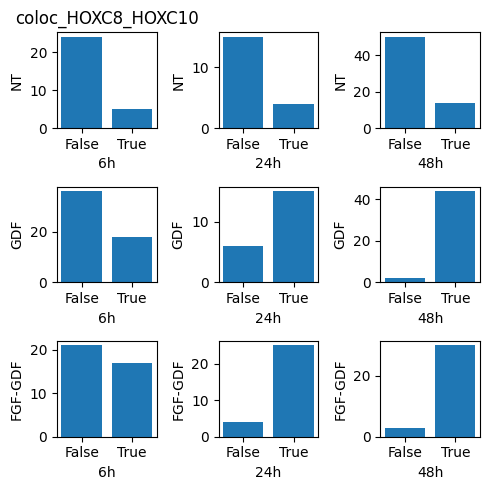

In [17]:
name_coloc  = 'coloc' + '_' + name_gene1 + '_' + name_gene2
name  = f'{modality}_{meth}_{name_gene1}_{name_gene2}'

file_add_mask_stats_g2  = constants[f"MASK_{modality}_{struc_cell}_STATS_{meth}_{chan_g2}_LIST_PATH"]
dic_masks_cell_stats_g2 = fp.load_pd_distributed_files(file_add_mask_stats_g2)


fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for ind, file_name in enumerate(batch_fish_g1):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind] 
        
        count_ones  = np.sum(dic_masks_cell_stats_g2[file_base][name_coloc].values*1 == 1)
        count_zeros = np.sum(dic_masks_cell_stats_g2[file_base][name_coloc].values*1 == 0)
        
        axes[ind_l, ind_c].bar([0, 1], [count_zeros, count_ones], tick_label=['False', 'True'])
        axes[ind_l, ind_c].set_xlabel(leg_x[ind_c])
        axes[ind_l, ind_c].set_ylabel(leg_y[ind_l])
        if ind_l == 0 and ind_c ==0:
            axes[ind_l, ind_c].set_title(f'{name_coloc}')
 
fig.tight_layout()
fig.savefig(Path(f"../Analysis/{batch_name}/Figures/{batch_name}_bin_coloc_{name}.png"), bbox_inches="tight")  

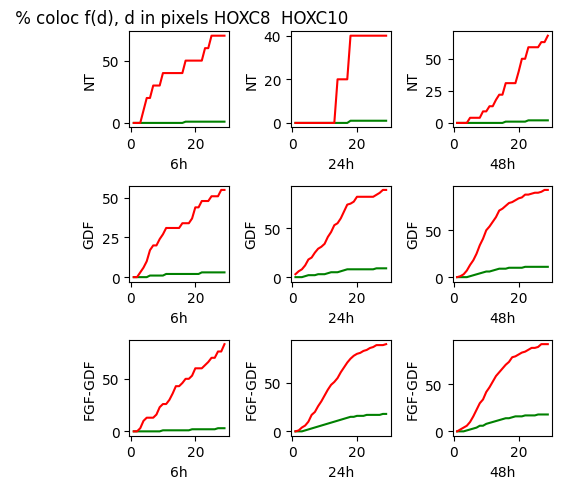

In [18]:
d_inter   = np.arange(1, 30)                    # colocalization distances

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for ind, file_name in enumerate(batch_fish_g1):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind]
        
        df1 = dict_dots_g1[file_base]
        spots_filt_g1 = df1[df1['in_mask'] == True][['Y','X']].to_numpy()

        df2 = dict_dots_g2[file_base]
        spots_filt_g2 = df2[df2['in_mask'] == True][['Y','X']].to_numpy()
        
        coloc_f_z_g1 = np.zeros_like(d_inter)
        coloc_f_z_g2 = np.zeros_like(d_inter)

        for ind, d in enumerate(d_inter):    
            list_gene1_only, list_gene2_only, list_gene1_gene2 = st.colocalization_analysis(spots_filt_g1, spots_filt_g2, thresh_dist=d)
            coloc_f_z_g1[ind] = 100*len(list_gene1_gene2)/(len(list_gene1_only) + len(list_gene1_gene2))
            coloc_f_z_g2[ind] = 100*len(list_gene1_gene2)/(len(list_gene2_only) + len(list_gene1_gene2))

        axes[ind_l, ind_c].plot(d_inter, coloc_f_z_g1, color= color_g1)
        axes[ind_l, ind_c].plot(d_inter, coloc_f_z_g2, color= color_g2)

        axes[ind_l, ind_c].set_xlabel(leg_x[ind_c])
        axes[ind_l, ind_c].set_ylabel(leg_y[ind_l])
        if ind_l == 0 and ind_c ==0:
            axes[ind_l, ind_c].set_title(f' % coloc f(d), d in pixels {name_gene1}  {name_gene2}')
            
fig.tight_layout()
fig.savefig(Path(f"../Analysis/{batch_name}/Figures/{batch_name}_coloc_f_d_{name}.png"), bbox_inches="tight")         

In [ ]:
# QC

In [19]:
mask_cell_path       = constants[f'MASK_{modality}_DAPI_{struc_cell}_CLEANED_LIST_PATH']   

dict_mask_cells_m    = fp.load_masks_distributed_files(mask_cell_path)  

view_coloc = napari.Viewer()
counter    = 0

for ind, file_name in enumerate(batch_fish_g1):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind]
        
        df1 = dict_dots_g1[file_base]
        spots_filt_g1 = df1[df1['in_mask'] == True][['Y','X']].to_numpy()

        df2 = dict_dots_g2[file_base]
        spots_filt_g2 = df2[df2['in_mask'] == True][['Y','X']].to_numpy()

        cell_layer = view_coloc.add_labels(dict_mask_cells_m[file_base], name=f"Cells {file_base}", opacity=.2, blending='translucent')
         
        view_coloc.add_points(spots_filt_g1, name=f"Spots gene {chan_g1} {file_base}", size=12, face_color=color_g1);
        view_coloc.add_points(spots_filt_g2, name=f"Spots gene {chan_g2} {file_base}", size=12, face_color=color_g2);

        if counter !=0:
            view_coloc.layers[f"Cells {file_base}"].visible                = False
            view_coloc.layers[f"Spots gene {chan_g1} {file_base}"].visible = False
            view_coloc.layers[f"Spots gene {chan_g2} {file_base}"].visible = False    
        counter = counter + 1